In [11]:
%%capture
%cd ../..

In [12]:
import psycopg
import numpy as np
import pandas as pd

#### Connect to PostgreSQL database

In [61]:
conn = psycopg.connect('postgresql://haberc@localhost:5432/mlflow_db')

#### Print DB version

In [15]:
cur = conn.cursor()
cur.execute("SELECT version();")
db_version = cur.fetchone()
print("Database version:", db_version)
cur.close()

Database version: (b'PostgreSQL 13.18 (Debian 13.18-1.pgdg120+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 12.2.0-14) 12.2.0, 64-bit',)


#### Get list of table names

In [16]:
cur = conn.cursor()
cur.execute("""
    SELECT table_schema, table_name
    FROM information_schema.tables
    WHERE table_schema NOT IN ('information_schema','pg_catalog');
""")
for schema, table in cur.fetchall():
    print(schema, table)
cur.close()

b'public' b'metrics'
b'public' b'tags'
b'public' b'runs'
b'public' b'experiments'
b'public' b'params'
b'public' b'alembic_version'
b'public' b'experiment_tags'
b'public' b'latest_metrics'
b'public' b'registered_models'
b'public' b'registered_model_tags'
b'public' b'model_version_tags'
b'public' b'registered_model_aliases'
b'public' b'datasets'
b'public' b'inputs'
b'public' b'input_tags'
b'public' b'model_versions'
b'public' b'trace_info'
b'public' b'trace_tags'
b'public' b'trace_request_metadata'


#### Get column names in a table

In [17]:
cur = conn.cursor()
table_name = 'metrics'  # or 'metrics', 'experiments', etc.
cur.execute(f"""
    SELECT column_name, data_type, is_nullable
    FROM information_schema.columns
    WHERE table_name='{table_name}';
""")
for col_name, data_type, nullable in cur.fetchall():
    print(col_name, data_type, nullable)
cur.close()

b'value' b'double precision' b'NO'
b'timestamp' b'bigint' b'NO'
b'step' b'bigint' b'NO'
b'is_nan' b'boolean' b'NO'
b'key' b'character varying' b'NO'
b'run_uuid' b'character varying' b'NO'


#### Get sample rows of a particular metric

In [18]:
cur = conn.cursor()
cur.execute("""
    SELECT r.run_uuid, m.key, m.value, m.timestamp
    FROM runs AS r
    JOIN metrics AS m
      ON r.run_uuid = m.run_uuid
    WHERE m.key = 'val_loss'
    ORDER BY m.timestamp DESC
    LIMIT 10;
""")
rows = cur.fetchall()
for row in rows:
    print(row)
cur.close()

(b'2584f01fc39d4c34873889aec3c52f40', b'val_loss', 0.046362895518541336, 1737429618743)
(b'2d838fe9ee074ae991c156994046486d', b'val_loss', 0.0033043138682842255, 1737429608348)
(b'2b87373685944d64ac3ffb841a24f13c', b'val_loss', 0.0005870313034392893, 1737429604020)
(b'2584f01fc39d4c34873889aec3c52f40', b'val_loss', 0.04606363922357559, 1737429598734)
(b'45ae77024d384aeb95c3d39050f827a3', b'val_loss', 0.08835887908935547, 1737429594450)
(b'2d838fe9ee074ae991c156994046486d', b'val_loss', 0.002942719729617238, 1737429588330)
(b'1b2daa558e644ce3a41ddfd9336820d7', b'val_loss', 0.014380989596247673, 1737429587329)
(b'9a56b82564a849e19bfd8159812cf3a6', b'val_loss', 0.02664834074676037, 1737429585934)
(b'89d7238017654278b82dae381e17572c', b'val_loss', 0.005060948897153139, 1737429583394)
(b'2b87373685944d64ac3ffb841a24f13c', b'val_loss', 0.0006275245686993003, 1737429583083)


#### Utilize function that opens and closes the cursor

In [19]:
def execute_query(query, conn, limit=None):
    if limit:
        query += f" LIMIT {limit};"
    with conn.cursor() as cursor:
        cursor.execute(query)
        return cursor.fetchall()

In [20]:
query = """
SELECT r.run_uuid,
       p.value         AS term_expression,
       m.key           AS metric_key,
       m.value         AS metric_value,
       m.timestamp     AS metric_timestamp
  FROM runs r
  JOIN params p
    ON r.run_uuid = p.run_uuid
  JOIN metrics m
    ON r.run_uuid = m.run_uuid
 WHERE p.key = 'expression'
 ORDER BY r.run_uuid, m.key
"""

In [21]:
execute_query(query=query, conn=conn, limit=10)

[(b'00089b1e345f4cd7b731268ef95402e2',
  b'subset_eq(index(cardinality(intersection(A, B)), union(difference(A, B), difference(B, A))), union(index(cardinality(A), B), index(cardinality(B), union(A, B))))',
  b'epoch',
  0.0,
  1737372433357),
 (b'00089b1e345f4cd7b731268ef95402e2',
  b'subset_eq(index(cardinality(intersection(A, B)), union(difference(A, B), difference(B, A))), union(index(cardinality(A), B), index(cardinality(B), union(A, B))))',
  b'epoch',
  0.0,
  1737372454144),
 (b'00089b1e345f4cd7b731268ef95402e2',
  b'subset_eq(index(cardinality(intersection(A, B)), union(difference(A, B), difference(B, A))), union(index(cardinality(A), B), index(cardinality(B), union(A, B))))',
  b'epoch',
  0.0,
  1737372417797),
 (b'00089b1e345f4cd7b731268ef95402e2',
  b'subset_eq(index(cardinality(intersection(A, B)), union(difference(A, B), difference(B, A))), union(index(cardinality(A), B), index(cardinality(B), union(A, B))))',
  b'epoch',
  0.0,
  1737372424821),
 (b'00089b1e345f4cd7b731

#### Get a sample of logged parameter key names

In [22]:
cur = conn.cursor()
cur.execute("""
    SELECT DISTINCT key
    FROM params
    LIMIT 500;
""")
rows = cur.fetchall()
for key in rows:
    print("key=", key)
cur.close()

key= (b'expressions_generation_args_n_limit',)
key= (b'expressions_representation',)
key= (b'childrun_seed',)
key= (b'optimizer_lr',)
key= (b'foreach',)
key= (b'tracking_port',)
key= (b'training_k_splits',)
key= (b'expressions_generation_args_inclusive',)
key= (b'grammar_path',)
key= (b'training_device',)
key= (b'model__target_',)
key= (b'experiment_name',)
key= (b'differentiable',)
key= (b'expressions_index',)
key= (b'weight_decay',)
key= (b'training_early_stopping_patience',)
key= (b'training_early_stopping_mode',)
key= (b'grammar_indices',)
key= (b'model_input_dim',)
key= (b'training_early_stopping_min_delta',)
key= (b'grammar_index_weight',)
key= (b'training_lightning',)
key= (b'expressions_downsampling',)
key= (b'measures_monotonicity_direction',)
key= (b'optimizer__target_',)
key= (b'measures_target',)
key= (b'expressions_batch_size',)
key= (b'capturable',)
key= (b'lr',)
key= (b'epochs',)
key= (b'model_seq_len',)
key= (b'maximize',)
key= (b'measures_monotonicity_debug',)
key= (b'

### Sample the distinct metrics available

In [23]:
query = """SELECT DISTINCT key
FROM metrics
ORDER BY key
LIMIT 50;  -- or however many rows you'd like to sample
"""
execute_query(query=query, conn=conn)

[(b'epoch',),
 (b'global_step',),
 (b'monotonicity_entropic',),
 (b'train_loss',),
 (b'train_loss_epoch',),
 (b'train_loss_step',),
 (b'val_loss',),
 (b'val_loss_epoch',),
 (b'val_loss_running_avg50',),
 (b'val_loss_step',)]

### Query to get the earliest training step before a particular val loss

In [32]:
earliest_query = """SELECT
    p.value AS expression,
    COALESCE(MIN(m.step)::text, 'does not exist') AS first_step
FROM runs r
JOIN params p
    ON r.run_uuid = p.run_uuid
    -- We'll get all expressions from the params table
    -- but only those with p.key = 'expression'
    AND p.key = 'expression'
LEFT JOIN metrics m
    ON r.run_uuid = m.run_uuid
    -- We only want rows where the metric is `val_loss_running_avg50` AND < 0.05
    AND m.key = 'val_loss_running_avg50'
    AND m.value < 0.05
GROUP BY p.value
ORDER BY p.value
"""

#### Add in join on expression_id / name to limit to particular experiments

In [58]:
earliest_query_2 = """
SELECT
    p.value AS expression,
    COALESCE(MIN(m.step)::text, 'does not exist') AS first_step
FROM runs r
-- Join the experiment so we can filter by its name
JOIN experiments e
    ON r.experiment_id = e.experiment_id
-- Get your 'expression' parameter
JOIN params p
    ON r.run_uuid = p.run_uuid
   AND p.key = 'expression'
-- Optional LEFT JOIN on metrics for the earliest step below threshold
LEFT JOIN metrics m
    ON r.run_uuid = m.run_uuid
   AND m.key = 'val_loss_running_avg50'
   AND m.value < 0.05
-- Filter by experiment name
WHERE e.name = 'expressions_shuffled_2k'
GROUP BY p.value
ORDER BY p.value;
"""

In [59]:
earliest_query_3 = """
SELECT
    p.value AS expression,
    COALESCE(MIN(m.step)::text, 'does not exist') AS first_step
FROM runs r
JOIN params p
    ON r.run_uuid = p.run_uuid
   AND p.key = 'expression'
LEFT JOIN metrics m
    ON r.run_uuid = m.run_uuid
   AND m.key = 'val_loss_running_avg50'
   AND m.value < 0.05
WHERE r.experiment_id = 42  -- <--- your experiment's numeric ID - 40 is expressions_shuffled_2k, 42 is 'repeated_runs'
GROUP BY p.value
ORDER BY p.value;
"""

In [62]:
earliest_result = execute_query(query=earliest_query_3, conn=conn)

In [63]:
len(earliest_result)

2000

##### Get id with name of experiment

In [28]:
query = """SELECT experiment_id
FROM experiments
WHERE name = 'repeated_runs';
"""

In [29]:
execute_query(query=query, conn=conn)

[(42,)]

#### Create dataframe of expressions and associated metrics

In [34]:
import pandas as pd

In [77]:
df = pd.DataFrame(earliest_result, columns=['expression', 'first_step'])

In [78]:
# Decode bytes to strings

def decode_if_bytes(x):
    if isinstance(x, bytes):
        return x.decode("utf-8")
    return x

df["expression"] = df["expression"].apply(decode_if_bytes)
df["first_step"] = df["first_step"].apply(decode_if_bytes)

### Get runs for which there was no training done

In [66]:
no_training_query = """SELECT DISTINCT pexp.value AS expression
FROM runs r
JOIN params pexp
  ON r.run_uuid = pexp.run_uuid
  AND pexp.key = 'expression'
LEFT JOIN metrics m
  ON r.run_uuid = m.run_uuid
  AND m.key = 'val_loss_running_avg50'
WHERE m.run_uuid IS NULL
ORDER BY pexp.value;
"""

In [67]:
no_training_result = execute_query(query=no_training_query, conn=conn)
no_training_df = pd.DataFrame(no_training_result)
no_training_df = no_training_df.applymap(decode_if_bytes)
no_training_df.columns = ['expression']

/var/folders/ww/zmy65s114cv2_jtlds20mdzc0000gn/T/ipykernel_26701/3702552904.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


#### Merge results into main dataframe

In [68]:
df["no_training"] = df["expression"].isin(no_training_df["expression"])

### Get monotonicity for all expressions

In [69]:
mono_query = """SELECT DISTINCT pexp.value AS expression,
       m.value AS monotonicity_entropic
FROM runs r
JOIN params pexp
  ON r.run_uuid = pexp.run_uuid
  AND pexp.key = 'expression'
JOIN metrics m
  ON r.run_uuid = m.run_uuid
  AND m.key = 'monotonicity_entropic'
ORDER BY expression;"""

In [70]:
monotonicity_results = execute_query(query=mono_query, conn=conn)

In [71]:
mono_df = pd.DataFrame(monotonicity_results)
mono_df = mono_df.applymap(decode_if_bytes)
mono_df.columns = ['expression', 'monotonicity_entropic']

/var/folders/ww/zmy65s114cv2_jtlds20mdzc0000gn/T/ipykernel_26701/981420326.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


### Get depth

In [72]:
depth_query = """SELECT DISTINCT pexp.value AS expression,
       pdepth.value AS expression_depth
FROM runs r
JOIN params pexp
  ON r.run_uuid = pexp.run_uuid
  AND pexp.key = 'expression'
JOIN params pdepth
  ON r.run_uuid = pdepth.run_uuid
  AND pdepth.key = 'expression_depth'
ORDER BY expression;"""

In [73]:
depth_results = execute_query(query=depth_query, conn=conn)
depth_df = pd.DataFrame(depth_results)
depth_df = depth_df.applymap(decode_if_bytes)
depth_df.columns = ['expression', 'expression_depth']

/var/folders/ww/zmy65s114cv2_jtlds20mdzc0000gn/T/ipykernel_26701/2764423100.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [74]:
depth_df['expression_depth'].value_counts()

expression_depth
4    1868
3     122
2      11
1       3
Name: count, dtype: int64

### Merge all data

In [75]:
final_df = df.merge(mono_df, on='expression').merge(depth_df, on='expression')
final_df["first_step"] = final_df["first_step"].replace("does not exist", np.nan)
final_df["first_step"] = final_df["first_step"].astype("Int64")

In [76]:
final_df.to_csv('learn_quant/analysis/repeated_runs.csv', index=False)

In [ ]:
# final_df.to_csv('learn_quant/analysis/expressions_shuffled_2k.csv', index=False)

In [79]:
final_df = pd.read_csv('learn_quant/analysis/repeated_runs.csv')

In [80]:
# Where did training occur, but the condition was not satisfied?
trained = final_df[final_df['no_training'] == False]
trained.loc[trained['first_step'].notnull()]

,expression,first_step,no_training,monotonicity_entropic,expression_depth
2,"and(and(not(subset_eq(A, B)), greater_than(car...",11092.0,False,0.358207,4
5,"and(and(not(subset_eq(A, B)), subset_eq(A, dif...",745.0,False,0.347243,4
6,"and(and(not(subset_eq(A, B)), subset_eq(A, dif...",957.0,False,0.260211,4
7,"and(and(not(subset_eq(B, A)), greater_than(car...",8520.0,False,0.328792,4
9,"and(and(not(subset_eq(B, A)), greater_than(car...",5573.0,False,0.439034,4
...,...,...,...,...,...
1989,"subset_eq(union(intersection(A, B), index(card...",710.0,False,0.000000,4
1990,"subset_eq(union(intersection(A, B), index(card...",2458.0,False,0.000000,4
1991,"subset_eq(union(intersection(A, B), index(card...",13331.0,False,0.000000,4
1993,"subset_eq(union(intersection(A, B), index(card...",877.0,False,0.260211,4


In [ ]:
# Creating the plot
from plotnine import element_line, stat_smooth, element_text, annotate,element_rect, element_blank, theme_minimal, theme, ggplot, geom_point, labs

plotdf = trained.copy()

# Replace "does not exist" (if present) with NaN in both columns
plotdf["first_step"] = plotdf["first_step"].replace("does not exist", np.nan)
plotdf["first_step"] = plotdf["first_step"].astype(float)
plotdf["monotonicity_entropic"] = plotdf["monotonicity_entropic"].replace("does not exist", np.nan)

# Convert to numeric (this will turn valid strings like "2648" into 2648.0)
plotdf["first_step"] = pd.to_numeric(plotdf["first_step"], errors="coerce")
plotdf["monotonicity_entropic"] = pd.to_numeric(plotdf["monotonicity_entropic"], errors="coerce")

# Drop rows where either is NaN
plotdf.dropna(subset=["first_step", "monotonicity_entropic"], inplace=True)

plot = (
    ggplot(plotdf, aes(y='monotonicity_entropic', x='first_step')) +
    geom_point(alpha=0.15, color='#0073C2') +
    theme_minimal() +
    stat_smooth(method='lm', color='red', linetype='dashed', se=False) +  # Add line of best fit (linear model)
    theme(
        plot_background=element_rect(fill="white", color="white"),  # White background
        panel_background=element_rect(fill="white", color="white"),   # White panel
        panel_grid_major=element_line(color="gray", size=0.5, linetype='dashed'),  # Dashed grid lines
        panel_grid_minor=element_line(color="lightgray", size=0.25, alpha=0.15),  # Minor grid lines
        plot_title=element_text(ha='center', size=16, weight='bold'),  # Bold, centered title
        axis_title=element_text(size=14, weight='bold'),  # Bold axis titles
        axis_text=element_text(size=12),  # Adjust axis text size
        axis_line=element_line(color="black", size=0.8),  # Add strong axis lines
        axis_ticks=element_line(color="black"),  # Add clean ticks
        legend_position="right"
    ) +
    labs(title='Expression Monotonicity vs Training Step',
         y='Monotonicity',
         x='Training Step',
         color='Legend')
         
    #annotate('text', x=0.2, y=0.3, label="linear fit", size=10, color="red")  # Line formula annotation
)
plot.save("monotonicity_vs_training_step.png", dpi=300,)  # Save as PNG with 300 DPI
plot

NameError: name 'trained' is not defined

In [ ]:
# We will need to round the values to bin values near to 0 or 1 (then rerun the plot)
plotdf['monotonicity_entropic'].astype(float).value_counts().sort_values()
plotdf["monotonicity_4sig"] = plotdf["monotonicity_entropic"].apply(
    lambda x: float(f"{x:.4g}")
)
plotdf["monotonicity_4sig"].value_counts().sort_values()

In [51]:
from scipy.stats import spearmanr, pearsonr

# Perform Spearman and Pearson correlation tests
spearman_corr, spearman_pval = spearmanr(plotdf["monotonicity_entropic"], plotdf["first_step"])
pearson_corr, pearson_pval = pearsonr(plotdf["monotonicity_entropic"], plotdf["first_step"])

# Display the results
{
    "Spearman Correlation": spearman_corr,
    "Spearman P-Value": spearman_pval,
    "Pearson Correlation": pearson_corr,
    "Pearson P-Value": pearson_pval
}

{'Spearman Correlation': -0.10901224403713969,
 'Spearman P-Value': 0.0001310405769885041,
 'Pearson Correlation': -0.16724347459584146,
 'Pearson P-Value': 3.82757258532382e-09}

#### Get distribution plot of monotonicity values

/Users/radmajik/anaconda3/envs/altk/lib/python3.12/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/radmajik/anaconda3/envs/altk/lib/python3.12/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: monotonicity_distribution_density.png


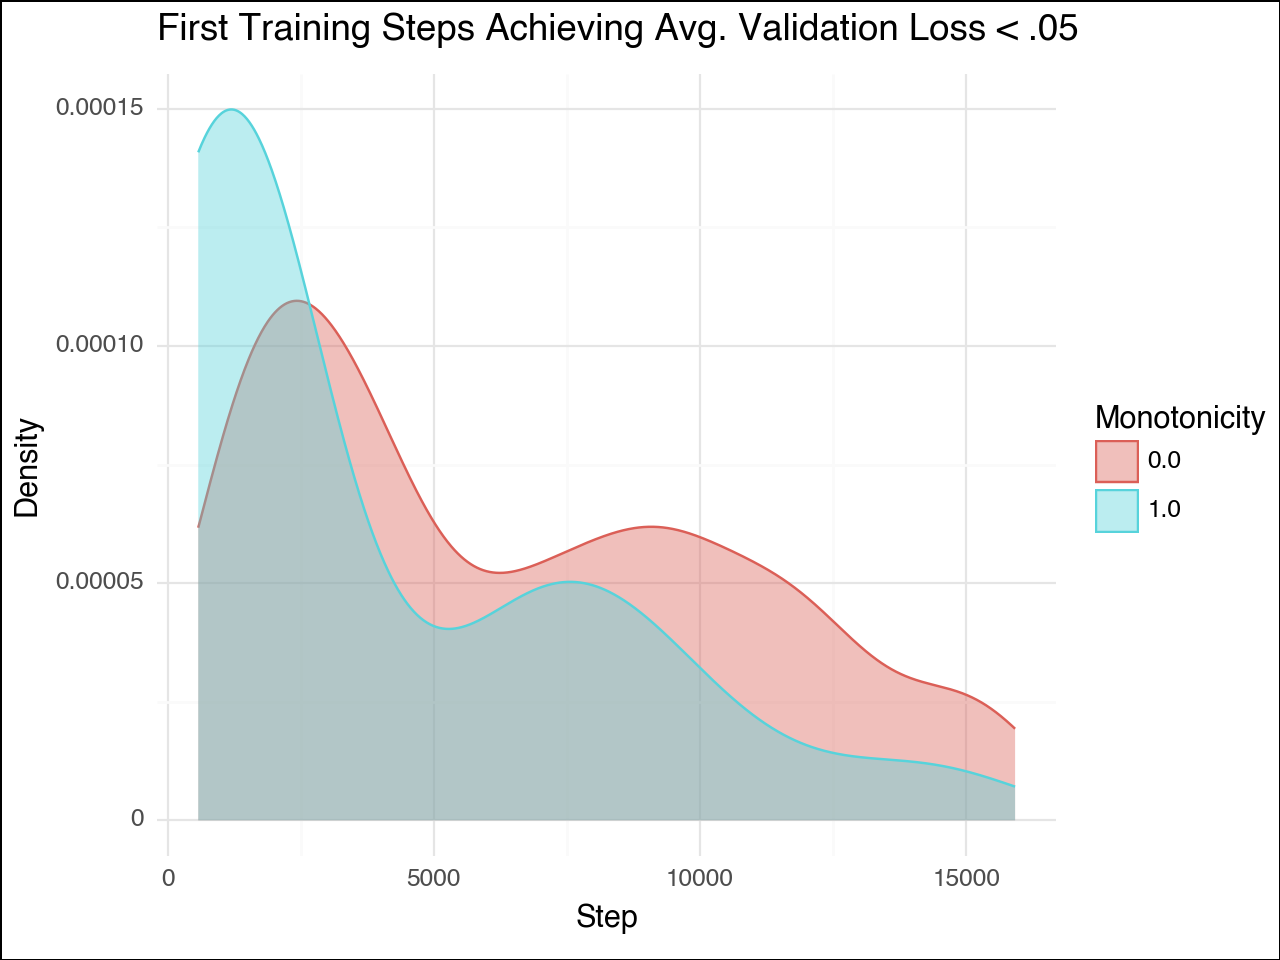

<Figure Size: (640 x 480)>

In [75]:
from plotnine import (
    ggplot, aes, geom_density, theme, labs, theme_minimal, element_blank,
)

# Subset to monotonicity = 0 or 1 only
plotdf_01 = plotdf[plotdf["monotonicity_4sig"].isin([0, 1])].copy()

# Convert monotonicity to a string/factor for coloring
plotdf_01["monotonicity_4sig"] = plotdf_01["monotonicity_4sig"].astype(str)

plot = (
    ggplot(plotdf_01, aes(x="first_step", 
                          color="monotonicity_4sig", 
                          fill="monotonicity_4sig"))
    + geom_density(alpha=0.4)  # semi-transparent so they overlap visibly
    + theme_minimal()
    + theme(
        panel_border=element_blank(),
        panel_background=element_rect(fill="white"),
        plot_background=element_rect(fill="white")
    )
    + labs(
        title="First Training Steps Achieving Avg. Validation Loss < .05",
        x="Step",
        y="Density",
        color="Monotonicity",
        fill="Monotonicity"
    )
    # Optional custom color/fill if you want specific colors:
    # + scale_color_manual(values=["#0073C2", "red"])
    # + scale_fill_manual(values=["#0073C2", "red"])
)
plot.save("monotonicity_distribution_density.png", dpi=300, transparent=False)
plot


In [64]:
# Observe counts of binned monotonicity values
plotdf[plotdf["monotonicity_4sig"].isin([0, 1])]['monotonicity_4sig'].value_counts()

monotonicity_4sig
0.0    443
1.0     48
Name: count, dtype: int64